## Utility functions for Droplet MD Simulation Post-Processing

The following Notebook contains all functions for making use of the MD simulation trajectory files in PDB Format to obtain spatial density profile which is used to obtain the droplet diameter and droplet contact angle. The key parameters that need to specified in the cells that follows are : **N_molecules, N_timesteps, xlim, ylim, zlim and the filename passed to get_txt function which converts a PDB file to txt format**. 

In the computation of density, the user may choose to specify any other cell_size. dx and dz determine the grid spacing in the X and Z directions on which the computation is made approximating each dx.dz sized box as a cuboid.

As long as the standard PDB format file is used, none of the functions may be changed internally.

*Note - The drop is assumed to be resting on a substrate on the X-Y plane and the Z direction is normal to the substrate. This tutorial was used for a water droplet.*

In [1]:
import IO_Lib as io
import density_Lib as rhofns
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
@jit
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [3]:
N_molecules = 1981 #Number of molecules having atom : atomname
N_timesteps = 200 #Number of time steps for which N_molecules trajectory was stored
Xlim = [0,240] #Max Limits on X coord (Based on Box Dimensions)
Ylim = [0,240] #Max Limits on Y coord
Zlim = [0,90]  #Max Limits on Z coord

In [4]:
#Example : Generate txt file of coordinates of oxygen ('O') from pdb file with name 'e=0.5_E=0' 
io.gen_txt('./PDB/','e=2.5_E=0','O')

In [5]:
X,Y,Z = io.get_coordinates('e=2.5_E=0', N_molecules, N_timesteps)
dx = 0.05 #Step-size in x direction
dz = 0.05 #Step-size in y direction
q = 1.5 #Padding
Nx = int(1/dx)
Nz = int(1/dz)
cell_size = 6.8
z_lvl = 10 #Z-level where the contact diameter is evaluated

In [6]:
#Get the Diameter List (this is slow!)
D = [] #Dia List
Nx = int(1/dx) #Number of nodes in X
Nz = int(1/dz) #Number of nodes in Y
for t in range(50,100):
    x0,y0,z0 = io.get_clean_coord(X,Y,Z,t, Xlim, Ylim, Zlim)
    xlim = [int(x0.min()-q),int(np.ceil(x0.max())+q)] #New Limits
    ylim = [int(y0.min()-q),int(np.ceil(y0.max())+q)] #New Limits
    zlim = [int(z0.min()-q),int(np.ceil(z0.max())+q)] #New Limits
    rho = rhofns.get_rho(6.8,np.asarray(xlim),np.asarray(ylim),np.asarray(zlim),x0,y0,z0,dx,dz) #Get rho Cell_Size of 6.8
    density_array = np.histogram(rho.flatten(),bins=1000)
    l = np.argmax(density_array[0][1:]) #Get location of second max (after 0) in the freq. histogram
    r = density_array[1][l+1] #Get density at the location
    d = find_nearest(rho[:,z_lvl*Nz][int(rho.shape[0]/2):],r/2)+int(rho.shape[0]/2) -find_nearest(rho[:,z_lvl*Nz][0:int(rho.shape[0]/2)],r/2)
    D.append(d*dx)

Text(0.5, 0, 'Timestep')

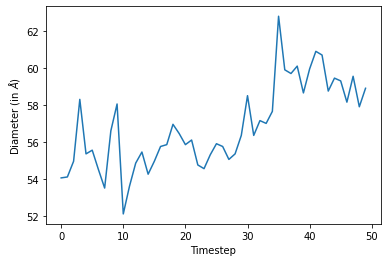

In [7]:
plt.plot(D)
plt.ylabel(r'Diameter (in $\AA$)')
plt.xlabel('Timestep')

In [8]:
x0,y0,z0 = io.get_clean_coord(X,Y,Z,99,Xlim,Ylim,Zlim)
q=1.5

Text(0.5, 0, 'z-distance from bottom')

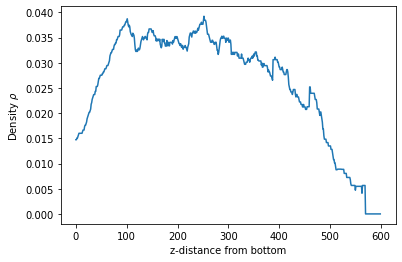

In [9]:
xlim = [int(x0.min()),int(np.ceil(x0.max()))] #New Limits
ylim = [int(y0.min()),int(np.ceil(y0.max()))] #New Limits
zlim = [int(z0.min()),int(np.ceil(z0.max()))] #New Limits
rho = rhofns.get_rho(6.8,np.asarray(xlim),np.asarray(ylim),np.asarray(zlim),x0,y0,z0,dx,dz)
z_axis = np.linspace(0,zlim[1]-zlim[0])
plt.plot(rho[int(rho.shape[0]*0.5),:]/(cell_size*cell_size))
plt.ylabel(r'Density $ \rho $')
plt.xlabel('z-distance from bottom')

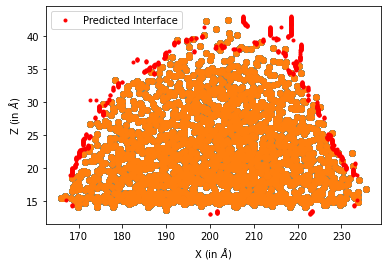

In [10]:
dx = 0.05
dz = 0.05
Nx = int(1/dx)
Nz = int(1/dz)
x0,y0,z0 = io.get_clean_coord(X,Y,Z,120,Xlim,Ylim,Zlim) #At 100th timestep
xlim = [int(x0.min()),int(np.ceil(x0.max()))]
ylim = [int(y0.min()),int(np.ceil(y0.max()))]
zlim = [int(z0.min()),int(np.ceil(z0.max()))]
rho = rhofns.get_rho(cell_size,np.asarray(xlim),np.asarray(ylim),np.asarray(zlim),x0,y0,z0,dx,dz) #Get rho Cell_Size of 6.8
density_array = np.histogram(rho.flatten(),bins=1000)
l = np.argmax(density_array[0][1:]) #Get location of second max (after 0) in the freq. histogram
r = density_array[1][l+1] #Get density at the location
left_pts = []
right_pts = []
for z in range(0,rho.shape[1]):
    p1 = find_nearest(rho[:,int(z)],r/2)
    temp_idx = min(p1+int(rho.shape[0]*0.25),int(rho.shape[0]*0.75))
    p2 = find_nearest(rho[:,int(z)][temp_idx:],r/2)+temp_idx
    if p2 > p1:
        plt.plot(p1/Nx+xlim[0], z/Nz+zlim[0],'r.')
        left_pts.append([p1/Nx+xlim[0], z/Nz+zlim[0]])
        plt.plot(p2/Nx+xlim[0], z/Nz+zlim[0],'r.')
        right_pts.append([p2/Nx+xlim[0], z/Nz+zlim[0]])
        plt.scatter(x0,z0)
        plt.xlabel(r'X (in $\AA$)')
        plt.ylabel(r'Z (in $\AA$)')
        plt.legend(['Predicted Interface'])

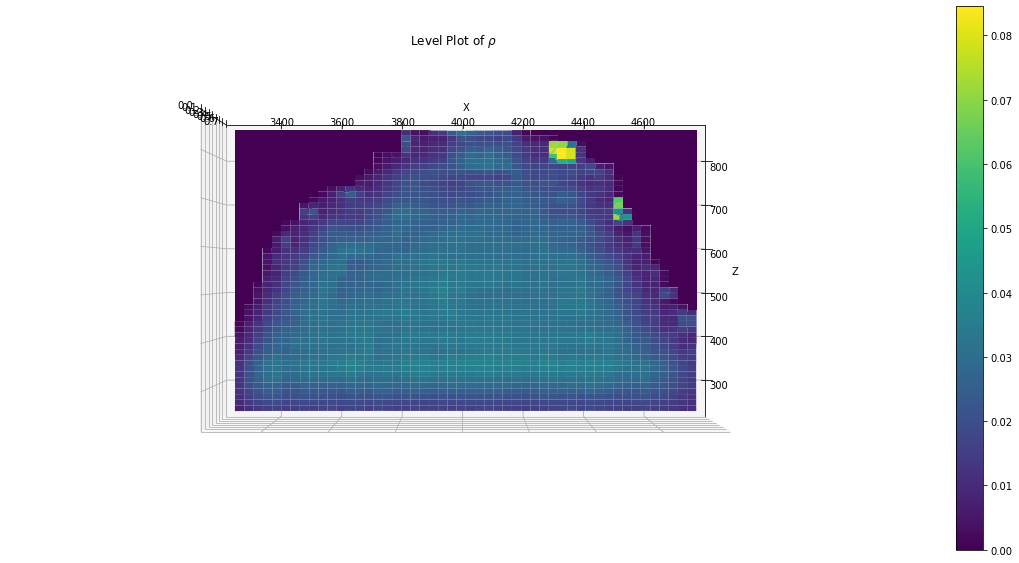

In [11]:
#Level Plot of Rho
rhofns.plot_rho(rho/(cell_size*cell_size),xlim,zlim,dx,dz)


In [12]:
density_array = np.histogram(rho.flatten()/(cell_size*cell_size),bins=1000)
l = np.argmax(density_array[0][1:]) #Get location of second max (after 0) in the freq. histogram
n = density_array[1][l+1] #Get density at the location

N_A = 6.022*1e23 # Avogadro's Number
L_c = 1e-10 # 1 Angstorm to meter
M_Mass = 18 # Molecular Mass of Water

print('Predicted # Density of Water : ',n, '\n')
print('Predicted Density of Water:', n*18*1e-6/(N_A*L_c**3),'g/cc')


Predicted # Density of Water :  0.03171856978085232 

Predicted Density of Water: 0.9480807971692821 g/cc


In [13]:
left_arr = np.squeeze(np.asarray(left_pts))
right_arr = np.squeeze(np.asarray(right_pts))

Text(205.6914295015313, 25, 'Left Angle:59.65')

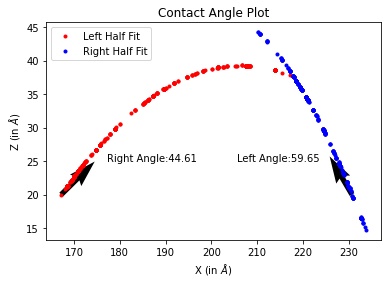

In [14]:
from scipy.optimize import curve_fit
def func(x,a,b,c):
    return a*x**2+b*x+c
def func_prime(x,a,b,c):
    return 2*a*x+b
    
zlevel = 20 #zlevel at which contact angle is measured


xdata = left_arr[:,0]
ydata = left_arr[:,1]
popt, pcov = curve_fit(func, xdata, ydata)

x_at_zlevel = (-popt[1]+np.sqrt(popt[1]**2-4*popt[0]*(popt[2]-zlevel)))/(2*popt[0])

v = np.array([1,func_prime(x_at_zlevel,*popt)])
origin = [x_at_zlevel],[zlevel]
right_angle = int(np.arctan(v[1]/v[0])*180/np.pi*100)/100
plt.quiver(*origin, v[0], v[1], color=['k'], scale=10, width=0.016)
plt.plot(xdata,func(xdata,*popt),'r.')
plt.text(x_at_zlevel+10,zlevel+5,'Right Angle:'+str(right_angle))

xdata = right_arr[:,0]
ydata = right_arr[:,1]
popt, pcov = curve_fit(func, xdata, ydata) #Fitting to get polynomial coefficients in popt

x_at_zlevel = (-popt[1]-np.sqrt(popt[1]**2-4*popt[0]*(popt[2]-zlevel)))/(2*popt[0])
v = np.array([-1,-func_prime(x_at_zlevel,*popt)])
origin = [x_at_zlevel],[zlevel]
left_angle = int(-np.arctan(v[1]/v[0])*180/np.pi*100)/100
plt.quiver(*origin, v[0], v[1], color=['k'], scale=15,width=0.016)

plt.plot(xdata,func(xdata,*popt),'b.')
plt.xlabel(r'X (in $\AA$)')
plt.ylabel(r'Z (in $\AA$)')
plt.title('Contact Angle Plot')
plt.legend(['Left Half Fit','Right Half Fit'])

plt.text(x_at_zlevel-25,zlevel+5,'Left Angle:'+str(left_angle))


In [ ]:
xdata = np.hstack((left_arr[:,0],right_arr[:,0]))
ydata = np.hstack((left_arr[:,1],right_arr[:,1]))

indices = np.argsort(xdata)
xdata = np.sort(xdata)
ynew = np.zeros(ydata.shape)
j = 0
for i in indices:
    ynew[j] = ydata[i]
    j=j+1

xdata = xdata[(ynew > 17 )]
ynew = ynew[(ynew > 17)]


In [ ]:
plt.scatter(xdata,ynew)

In [ ]:
from scipy.optimize import curve_fit
def func(x,a,b,c,d):
    return a*x**3+b*x**2+c*x+d

popt, pcov = curve_fit(func, xdata, ynew)

plt.plot(xdata,func(xdata,*popt),'r.')

plt.scatter(xdata,ynew)